### Random Forest

In [36]:
from Functions import get_result, get_best_threshold, plot_roc_curve, save_metrics_to_json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import pandas as pd
import pickle

Load the datasets for training (remember they are scaled)

In [3]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

In [4]:
# The scores we want to look at
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

#### Hyperparameter Tuning
Here we set up the hyperparameters we want to tune

In [5]:
param_grid = {
    'n_estimators': [50, 100, 250, 500],        # Number of trees
    'max_depth': [None, 10, 25, 50],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],           # Number of features to consider at each split
    'bootstrap': [True, False],                 # Method of selecting samples for training each tree
    'class_weight' : [None, 'balanced']         # Weights associated with classes (for imbalance)
}

In [6]:
# Initialize the RandomForestClassifier
rfc = RandomForestClassifier()

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(estimator=rfc, search_spaces=param_grid, 
                               n_iter=50, cv=3, verbose=1, random_state=42, n_jobs=-1,
                               scoring='f1', refit=True) # We use f1 for the scoring to find the parameters that maximize that


In [7]:
# Run the RandomizedSearchCV
bayes_search.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              random_state=42, scoring='f1',
              search_spaces={'bootstrap': [True, False],
                             'class_weight': [None, 'balanced'],
                             'max_depth': [None, 10, 25, 50],
                             'max_features': ['sqrt', 'log2'],
                             'min_samples_leaf': [1, 2, 4],
                             'min_samples_split': [2, 5, 10],
                             'n_estimators': [50, 100, 250, 500]},
              verbose=1)

In [8]:
# Look at the results of the hyperparameter tuning
rfc_tuning_df = pd.DataFrame(bayes_search.cv_results_['params'])
rfc_tuning_df['Mean_f1'] = bayes_search.cv_results_['mean_test_score']
rfc_tuning_df['std_f1_score'] = bayes_search.cv_results_['std_test_score']
rfc_tuning_df['Rank_F1'] = bayes_search.cv_results_['rank_test_score']
rfc_tuning_df.sort_values('Rank_F1')

,bootstrap,class_weight,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,Mean_f1,std_f1_score,Rank_F1
5,False,balanced,NaN,sqrt,4,5,100,0.253542,0.008661,1
8,False,balanced,50.0,sqrt,2,2,50,0.252860,0.008911,2
25,False,balanced,50.0,sqrt,4,5,50,0.252238,0.007050,3
43,False,balanced,NaN,sqrt,2,2,250,0.250885,0.004243,4
36,False,balanced,50.0,sqrt,2,10,250,0.250508,0.006440,5
18,False,balanced,50.0,log2,4,2,250,0.250409,0.010501,6
48,False,balanced,25.0,sqrt,4,10,250,0.250293,0.010650,7
27,False,balanced,NaN,sqrt,2,10,250,0.250229,0.004942,8
42,False,balanced,NaN,log2,2,10,100,0.250005,0.004993,9
46,False,balanced,50.0,sqrt,2,10,500,0.249776,0.004689,10


From the results above, we can see that using class_weight='balanced' is clearly best, which is not surprising, since we have a imbalanced dataset. 
<br>Next, we see that the higher values for min_samples_leaf is in the top. You could try to tune some more, with some higher values in min_samples_leaf, if you wanna see how much it could improve the model. We will however not do that here.
<br>Note also the accuracy for every model. The vast majority got an accuracy of 99% and even the models not predicting 1 risky customer right got it. 

Lets take the model with the hyperparameters that performed the best and test it on our test set and see how well it is doing.

In [9]:
best_rf_params = bayes_search.best_params_

In [10]:
best_rf = RandomForestClassifier(**best_rf_params)
best_rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       min_samples_leaf=4, min_samples_split=5)

In [11]:
# Save the best model
with open('Saved models/random_forest_best_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

In [12]:
# Predict on the val set
val_predictions = best_rf.predict_proba(X_val)[:, 1]

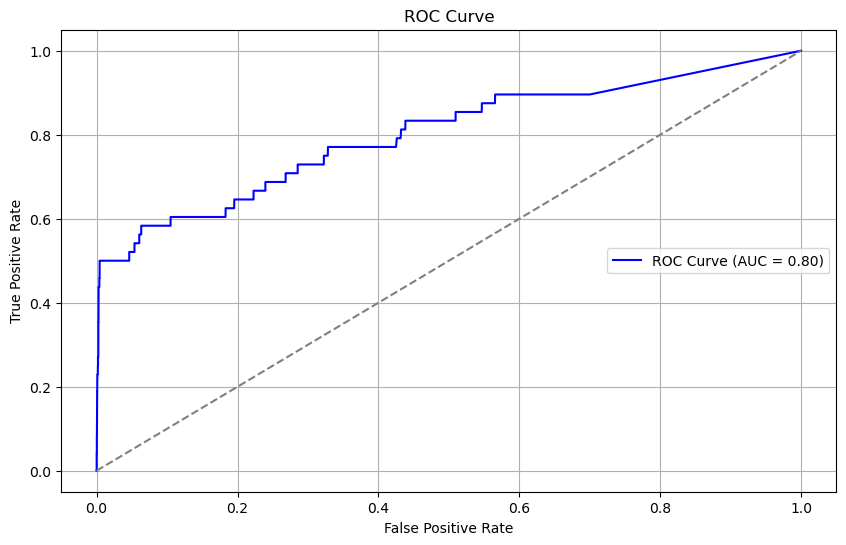

0.8003843190490167

In [13]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:65: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


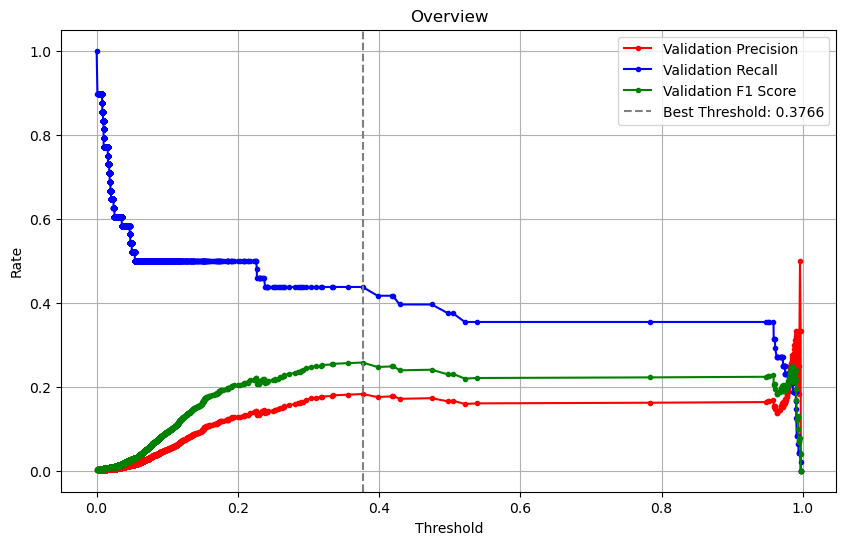

In [14]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [16]:
# Predict on the test set
test_predictions = best_rf.predict_proba(X_test)[:, 1]

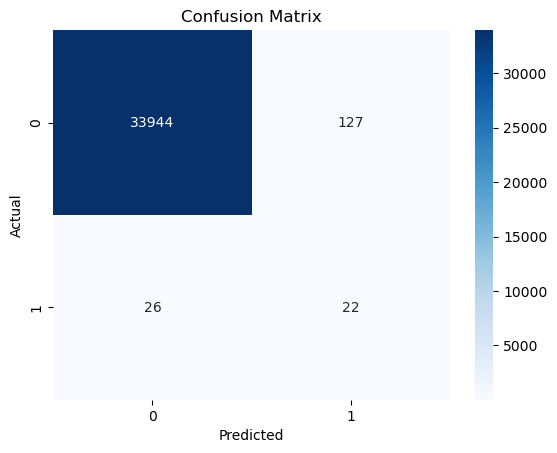

Recall       = 0.46
Precision    = 0.15
F1           = 0.22


In [17]:
result_1 = get_result(Y_test, test_predictions, best_threshold)

For training this model we did not use the validation set, which contains 10% of the original dataset. It could be interresting to see if the model, with the same parameters, could perform better on the test set if it had more data to train on. We'll keep the best threshold, since the model now have seen the data to construct the best threshold and thus be more sure than wants best in general.

Lets merge the training and validation set and predict on the test set again.

In [18]:
# Initialize the RandomForestClassifier with the best hyperparameters from the tuning phase
rfc = RandomForestClassifier(**best_rf_params)

In [19]:
# Train the model
rfc.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       min_samples_leaf=4, min_samples_split=5)

In [20]:
# Predict on the val set
val_predictions = rfc.predict_proba(X_val)[:, 1]

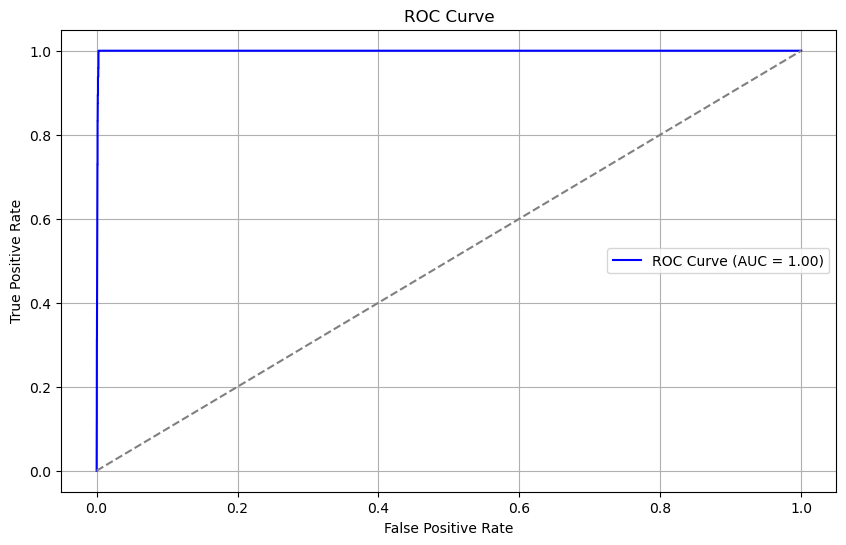

0.9991408619508855

In [21]:
plot_roc_curve(Y_val, val_predictions)

It does perfect on the ROC Curve, which is not surprising, since the model has been trained on the data

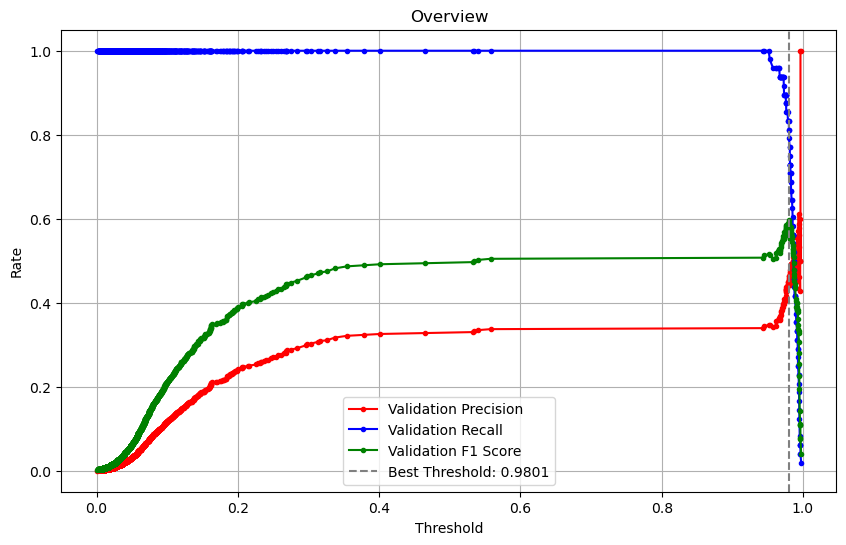

0.9800601911211895

In [22]:
get_best_threshold('Validation', Y_val, val_predictions)

As predicted the best threshold went from 0.37 to 0.98

In [23]:
# Predict on the test set
test_predictions = rfc.predict_proba(X_test)[:, 1]

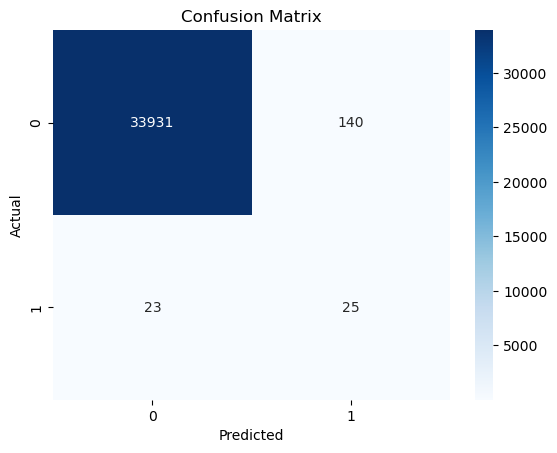

Recall       = 0.52
Precision    = 0.15
F1           = 0.23


In [24]:
result_2 = get_result(Y_test, test_predictions, best_threshold)

In [ ]:
if result_2['f1'] > result_1['f1']:
    with open('Saved models/random_forest_best_model.pkl', 'wb') as file:# Overwrite the previous best model
        pickle.dump(best_rf, file)
    save_metrics_to_json(
        model_name='RandomForest', 
        recall=result_2['recall'], 
        precision=result_2['precision'], 
        f1_score=result_2['f1'], 
        threshold=best_threshold
        )
    print('By training our model on more data, we achived a higher performance on the F1 score')
else:
    save_metrics_to_json('RandomForest', result_1['recall'], result_1['precision'], result_1['f1'], best_threshold)
    print('The first model we found, through hyperparameter tuning, is still our best model on the F1 score.')
    print('It had the following scores:')
    print('Recall       =', round(result_1['recall'], 2))
    print('Precision    =', round(result_1['precision'], 2))
    print('F1           =', round(result_1['f1'], 2))

By training our model on more data, we achived a higher performance on the F1 score
